<a href="https://colab.research.google.com/github/sidhu2690/TEST-REPO/blob/main/Pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/input/2a-data/HIGGS.csv.gz', header=None)

column_names = [
    'target', 'lepton_pt', 'lepton_eta', 'lepton_phi', 'met', 'met_phi',
    'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta',
    'jet2_phi', 'jet2_btag', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag',
    'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag', 'm_jj', 'm_jjj', 'm_lv',
    'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'
]

df.columns = column_names

print(df.head())

   target  lepton_pt  lepton_eta  lepton_phi       met   met_phi   jet1_pt  \
0     1.0   0.869293   -0.635082    0.225690  0.327470 -0.689993  0.754202   
1     1.0   0.907542    0.329147    0.359412  1.497970 -0.313010  1.095531   
2     1.0   0.798835    1.470639   -1.635975  0.453773  0.425629  1.104875   
3     0.0   1.344385   -0.876626    0.935913  1.992050  0.882454  1.786066   
4     1.0   1.105009    0.321356    1.522401  0.882808 -1.205349  0.681466   

   jet1_eta  jet1_phi  jet1_btag  ...  jet4_eta  jet4_phi  jet4_btag  \
0 -0.248573 -1.092064   0.000000  ... -0.010455 -0.045767   3.101961   
1 -0.557525 -1.588230   2.173076  ... -1.138930 -0.000819   0.000000   
2  1.282322  1.381664   0.000000  ...  1.128848  0.900461   0.000000   
3 -1.646778 -0.942383   0.000000  ... -0.678379 -1.360356   0.000000   
4 -1.070464 -0.921871   0.000000  ... -0.373566  0.113041   0.000000   

       m_jj     m_jjj      m_lv     m_jlv      m_bb     m_wbb    m_wwbb  
0  1.353760  0.979563  0

In [ ]:
data = df.iloc[:, 1:22]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000000 entries, 0 to 10999999
Data columns (total 21 columns):
 #   Column      Dtype  
---  ------      -----  
 0   lepton_pt   float64
 1   lepton_eta  float64
 2   lepton_phi  float64
 3   met         float64
 4   met_phi     float64
 5   jet1_pt     float64
 6   jet1_eta    float64
 7   jet1_phi    float64
 8   jet1_btag   float64
 9   jet2_pt     float64
 10  jet2_eta    float64
 11  jet2_phi    float64
 12  jet2_btag   float64
 13  jet3_pt     float64
 14  jet3_eta    float64
 15  jet3_phi    float64
 16  jet3_btag   float64
 17  jet4_pt     float64
 18  jet4_eta    float64
 19  jet4_phi    float64
 20  jet4_btag   float64
dtypes: float64(21)
memory usage: 1.7 GB


In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from torch import nn
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
def transform_data(data):
    phi_indices = [2, 4, 7, 11, 15, 19]
    transformed = []
    for i in range(21):
        if i in phi_indices:
            cos_phi = np.cos(data[:, i])
            sin_phi = np.sin(data[:, i])
            transformed.append(cos_phi)
            transformed.append(sin_phi)
        else:
            transformed.append(data[:, i])
    transformed = np.stack(transformed, axis=1)
    return transformed


data_np = data.to_numpy()
train_data = data_np[:1000000]
test_data_probe = data_np[1000000:1100000]
train_data_transformed = transform_data(train_data)
test_data_probe_transformed = transform_data(test_data_probe)

In [ ]:
train_data_transformed.shape

(1000000, 27)

In [ ]:
scaler = StandardScaler()
train_data_transformed_scaled = scaler.fit_transform(train_data_transformed)
test_data_probe_transformed_scaled = scaler.transform(test_data_probe_transformed)

In [ ]:
train_data_reshaped = torch.tensor(train_data_transformed_scaled, dtype=torch.float32).unsqueeze(-1)
dataset = TensorDataset(train_data_reshaped)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, pin_memory=True)
test_dataset = TensorDataset(torch.tensor(test_data_probe_transformed_scaled, dtype=torch.float32).unsqueeze(-1))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, pin_memory=True)

In [ ]:
class EnhancedTransformerEncoder(nn.Module):
    def __init__(self, input_dim=1, d_model=256, nhead=8, num_layers=4, dropout=0.3):
        super().__init__()
        self.feature_embed = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Embedding(27, d_model)
        self.dropout = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=4*d_model,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0).repeat(x.size(0), 1)
        x = self.feature_embed(x) + self.pos_encoder(positions)
        x = self.dropout(x)
        encoded = self.transformer(x)
        return encoded

class TransformerDecoder(nn.Module):
    def __init__(self, d_model=128, nhead=8, num_layers=3, dropout=0.2, seq_len=27, output_dim=1):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.tgt_emb = nn.Parameter(torch.randn(seq_len, d_model))
        self.pos_encoder = nn.Embedding(seq_len, d_model)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=4*d_model,
            dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, output_dim)

    def forward(self, memory):
        batch_size = memory.size(0)
        positions = torch.arange(0, self.seq_len, device=memory.device).unsqueeze(0).repeat(batch_size, 1)
        tgt = self.tgt_emb.unsqueeze(0).expand(batch_size, -1, -1) + self.pos_encoder(positions)
        decoder_output = self.transformer_decoder(tgt, memory)
        reconstructed = self.output_layer(decoder_output)
        return reconstructed

class EnhancedTransformerAE(nn.Module):
    def __init__(self, input_dim=1, d_model=128, nhead=8, num_layers=3, dropout=0.2, seq_len=27):
        super().__init__()
        self.encoder = EnhancedTransformerEncoder(input_dim, d_model, nhead, num_layers, dropout)
        self.decoder = TransformerDecoder(d_model, nhead, num_layers, dropout, seq_len, output_dim=input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded.mean(dim=1)

In [ ]:
#Compute visible transverse momentum components
def compute_pT_vis(x):
    pt_lepton = x[:, 0]
    phi_lepton = x[:, 2]
    pt_jet1 = x[:, 5]
    phi_jet1 = x[:, 7]
    pt_jet2 = x[:, 9]
    phi_jet2 = x[:, 11]
    pt_jet3 = x[:, 13]
    phi_jet3 = x[:, 15]
    pt_jet4 = x[:, 17]
    phi_jet4 = x[:, 19]
    px = (pt_lepton * torch.cos(phi_lepton) + pt_jet1 * torch.cos(phi_jet1) +
          pt_jet2 * torch.cos(phi_jet2) + pt_jet3 * torch.cos(phi_jet3) +
          pt_jet4 * torch.cos(phi_jet4))
    py = (pt_lepton * torch.sin(phi_lepton) + pt_jet1 * torch.sin(phi_jet1) +
          pt_jet2 * torch.sin(phi_jet2) + pt_jet3 * torch.sin(phi_jet3) +
          pt_jet4 * torch.sin(phi_jet4))
    return px, py

In [ ]:
#Compute missing transverse momentum components
def compute_pT_miss(x):
    met = x[:, 3]
    met_phi = x[:, 4]
    met_x = met * torch.cos(met_phi)
    met_y = met * torch.sin(met_phi)
    return met_x, met_y

In [ ]:
#Compute dijet invariant mass
def compute_m_jj(x):
    pt1 = x[:, 5]
    eta1 = x[:, 6]
    phi1 = x[:, 7]
    pt2 = x[:, 9]
    eta2 = x[:, 10]
    phi2 = x[:, 11]
    m2 = 2 * pt1 * pt2 * (torch.cosh(eta1 - eta2) - torch.cos(phi1 - phi2))
    m_jj = torch.sqrt(m2.clamp(min=0))
    return m_jj

In [ ]:
#Convert transformed features back to original 21-feature format.
def compute_original_features(transformed_features, means, stds):
    original_transformed = transformed_features * stds + means
    batch_size = original_transformed.size(0)
    original = torch.zeros(batch_size, 21, device=original_transformed.device)
    non_phi_trans_pos = torch.tensor([0, 1, 4, 7, 8, 11, 12, 13, 16, 17, 18, 21, 22, 23, 26],
                                    device=original_transformed.device)
    original_non_phi_indices = torch.tensor([0, 1, 3, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18, 20],
                                           device=original_transformed.device)
    original[:, original_non_phi_indices] = original_transformed[:, non_phi_trans_pos]
    phi_cos_sin_pos = [(2, 3), (5, 6), (9, 10), (14, 15), (19, 20), (24, 25)]
    original_phi_indices = [2, 4, 7, 11, 15, 19]
    for idx, (cos_pos, sin_pos) in enumerate(phi_cos_sin_pos):
        cos_phi = original_transformed[:, cos_pos]
        sin_phi = original_transformed[:, sin_pos]
        phi_recon = torch.atan2(sin_phi, cos_phi)
        original[:, original_phi_indices[idx]] = phi_recon
    return original

In [ ]:
# Custom Loss
def compute_losses(recon, batch, means, stds, criterion, alpha=1.0, beta=0.1, gamma=0.1, delta=1.0, epsilon=1.0, zeta=1.0):
    """Compute total loss with custom terms for phi, eta, and pT."""
    L_rec = criterion(recon, batch)

    batch_original = compute_original_features(batch.squeeze(-1), means, stds)
    recon_original = compute_original_features(recon.squeeze(-1), means, stds)

    phi_indices = [2, 4, 7, 11, 15, 19]
    L_phi = 0
    for i in phi_indices:
        delta_phi = torch.atan2(torch.sin(batch_original[:, i] - recon_original[:, i]),
                                torch.cos(batch_original[:, i] - recon_original[:, i]))
        L_phi += torch.mean(1 - torch.cos(delta_phi))
    L_phi /= len(phi_indices)

    eta_indices = [1, 6, 10, 14, 18]
    L_eta = 0
    for i in eta_indices:
        delta_eta = batch_original[:, i] - recon_original[:, i]
        L_eta += torch.mean(delta_eta ** 2 * torch.tanh(torch.abs(delta_eta)))
    L_eta /= len(eta_indices)

    pT_indices = [0, 3, 5, 9, 13, 17]
    eps = 0.1
    L_pT = 0
    for i in pT_indices:
        L_pT += torch.mean(((batch_original[:, i] - recon_original[:, i]) / (batch_original[:, i] + eps)) ** 2)
    L_pT /= len(pT_indices)

    # Momentum conservation loss
    px_vis_recon, py_vis_recon = compute_pT_vis(recon_original)
    met_x_recon, met_y_recon = compute_pT_miss(recon_original)
    L_mom = ((px_vis_recon + met_x_recon).pow(2) + (py_vis_recon + met_y_recon).pow(2)).mean()

    # Invariant mass loss
    m_jj_true = compute_m_jj(batch_original)
    m_jj_recon = compute_m_jj(recon_original)
    L_mass = (m_jj_recon - m_jj_true).pow(2).mean()

    # Total loss with all components
    L_total = alpha * L_rec + beta * L_mom + gamma * L_mass + delta * L_phi + epsilon * L_pT + zeta * L_eta
    return L_total, L_rec, L_mom, L_mass, L_phi, L_pT, L_eta

In [ ]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedTransformerAE().to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.SmoothL1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
means = torch.tensor(scaler.mean_, device=device, dtype=torch.float32)
stds = torch.tensor(scaler.scale_, device=device, dtype=torch.float32)

In [ ]:
# Training loop
best_val_loss = float('inf')
patience = 3
no_improve = 0

for epoch in range(30):
    model.train()
    train_loss, train_rec_loss, train_mom_loss, train_mass_loss, train_phi_loss, train_pT_loss, train_eta_loss = 0, 0, 0, 0, 0, 0, 0
    for batch in train_loader:
        batch = batch[0].to(device)
        optimizer.zero_grad()
        recon, _ = model(batch)
        L_total, L_rec, L_mom, L_mass, L_phi, L_pT, L_eta = compute_losses(
            recon, batch, means, stds, criterion, alpha=1.0, beta=0.5, gamma=0.5, delta=1.0, epsilon=1.0, zeta=1.0
        )
        L_total.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += L_total.item() * batch.size(0)
        train_rec_loss += L_rec.item() * batch.size(0)
        train_mom_loss += L_mom.item() * batch.size(0)
        train_mass_loss += L_mass.item() * batch.size(0)
        train_phi_loss += L_phi.item() * batch.size(0)
        train_pT_loss += L_pT.item() * batch.size(0)
        train_eta_loss += L_eta.item() * batch.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_rec_loss = train_rec_loss / len(train_loader.dataset)
    avg_train_mom_loss = train_mom_loss / len(train_loader.dataset)
    avg_train_mass_loss = train_mass_loss / len(train_loader.dataset)
    avg_train_phi_loss = train_phi_loss / len(train_loader.dataset)
    avg_train_pT_loss = train_pT_loss / len(train_loader.dataset)
    avg_train_eta_loss = train_eta_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_rec_loss, val_mom_loss, val_mass_loss, val_phi_loss, val_pT_loss, val_eta_loss = 0, 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch[0].to(device)
            recon, _ = model(batch)
            L_total, L_rec, L_mom, L_mass, L_phi, L_pT, L_eta = compute_losses(
                recon, batch, means, stds, criterion, alpha=1.0, beta=0.1, gamma=0.1, delta=1.0, epsilon=1.0, zeta=1.0
            )
            val_loss += L_total.item() * batch.size(0)
            val_rec_loss += L_rec.item() * batch.size(0)
            val_mom_loss += L_mom.item() * batch.size(0)
            val_mass_loss += L_mass.item() * batch.size(0)
            val_phi_loss += L_phi.item() * batch.size(0)
            val_pT_loss += L_pT.item() * batch.size(0)
            val_eta_loss += L_eta.item() * batch.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_rec_loss = val_rec_loss / len(val_loader.dataset)
    avg_val_mom_loss = val_mom_loss / len(val_loader.dataset)
    avg_val_mass_loss = val_mass_loss / len(val_loader.dataset)
    avg_val_phi_loss = val_phi_loss / len(val_loader.dataset)
    avg_val_pT_loss = val_pT_loss / len(val_loader.dataset)
    avg_val_eta_loss = val_eta_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} (Rec: {avg_train_rec_loss:.4f}, "
          f"Mom: {avg_train_mom_loss:.4f}, Mass: {avg_train_mass_loss:.4f}, Phi: {avg_train_phi_loss:.4f}, "
          f"pT: {avg_train_pT_loss:.4f}, Eta: {avg_train_eta_loss:.4f}) | "
          f"Val Loss: {avg_val_loss:.4f} (Rec: {avg_val_rec_loss:.4f}, "
          f"Mom: {avg_val_mom_loss:.4f}, Mass: {avg_val_mass_loss:.4f}, Phi: {avg_val_phi_loss:.4f}, "
          f"pT: {avg_val_pT_loss:.4f}, Eta: {avg_val_eta_loss:.4f})")

    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve = 0
        torch.save(model, "best_model.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping!")
            break

Epoch 001 | Train Loss: 1.1244 (Rec: 0.2817, Mom: 0.2544, Mass: 0.3345, Phi: 0.2860, pT: 0.1781, Eta: 0.0842) | Val Loss: 0.5498 (Rec: 0.2045, Mom: 0.1205, Mass: 0.0932, Phi: 0.2233, pT: 0.0994, Eta: 0.0012)
Epoch 002 | Train Loss: 0.6416 (Rec: 0.1875, Mom: 0.1851, Mass: 0.1035, Phi: 0.2167, pT: 0.0870, Eta: 0.0061) | Val Loss: 0.4815 (Rec: 0.1886, Mom: 0.0528, Mass: 0.0429, Phi: 0.2160, pT: 0.0664, Eta: 0.0009)
Epoch 003 | Train Loss: 0.5589 (Rec: 0.1779, Mom: 0.1685, Mass: 0.0805, Phi: 0.1917, pT: 0.0603, Eta: 0.0045) | Val Loss: 0.4203 (Rec: 0.1814, Mom: 0.0641, Mass: 0.0385, Phi: 0.1653, pT: 0.0624, Eta: 0.0009)
Epoch 004 | Train Loss: 0.4674 (Rec: 0.1594, Mom: 0.1550, Mass: 0.0615, Phi: 0.1389, pT: 0.0574, Eta: 0.0036) | Val Loss: 0.3600 (Rec: 0.1510, Mom: 0.0335, Mass: 0.0317, Phi: 0.1475, pT: 0.0544, Eta: 0.0005)
Epoch 005 | Train Loss: 0.4275 (Rec: 0.1448, Mom: 0.1241, Mass: 0.0510, Phi: 0.1401, pT: 0.0522, Eta: 0.0027) | Val Loss: 0.3437 (Rec: 0.1394, Mom: 0.0337, Mass: 0.0245

In [ ]:
# Evaluation
model = torch.load("best_model.pth", weights_only=False)
model.eval()
recon_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch[0].to(device)
        recon, _ = model(batch)
        recon_list.append(recon.cpu())
recon_tensor = torch.cat(recon_list, dim=0)

In [ ]:
recon_original_transformed = scaler.inverse_transform(recon_tensor.squeeze().numpy())
recon_original = np.zeros((recon_original_transformed.shape[0], 21))
non_phi_trans_pos = [0, 1, 4, 7, 8, 11, 12, 13, 16, 17, 18, 21, 22, 23, 26]
original_non_phi_indices = [0, 1, 3, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18, 20]
recon_original[:, original_non_phi_indices] = recon_original_transformed[:, non_phi_trans_pos]
phi_cos_sin_pos = [(2, 3), (5, 6), (9, 10), (14, 15), (19, 20), (24, 25)]
original_phi_indices = [2, 4, 7, 11, 15, 19]
for idx, (cos_pos, sin_pos) in enumerate(phi_cos_sin_pos):
    recon_original[:, original_phi_indices[idx]] = np.arctan2(
        recon_original_transformed[:, sin_pos], recon_original_transformed[:, cos_pos])

In [ ]:
test_original = test_data_probe

feature_names = column_names[1:22]
mse, mae, correlations = [], [], []
for i in range(21):
    if i in original_phi_indices:
        delta_phi = np.arctan2(np.sin(test_original[:, i] - recon_original[:, i]),
                              np.cos(test_original[:, i] - recon_original[:, i]))
        mse.append(np.mean(delta_phi ** 2))
        mae.append(np.mean(np.abs(delta_phi)))
    else:
        mse.append(mean_squared_error(test_original[:, i], recon_original[:, i]))
        mae.append(mean_absolute_error(test_original[:, i], recon_original[:, i]))
    correlations.append(pearsonr(test_original[:, i], recon_original[:, i])[0])

print("Feature-wise Reconstruction Metrics:")
for i, name in enumerate(feature_names):
    print(f"{name}: MSE={mse[i]:.4f}, MAE={mae[i]:.4f}, Pearson={correlations[i]:.4f}")

Feature-wise Reconstruction Metrics:
lepton_pt: MSE=0.0921, MAE=0.2143, Pearson=0.8755
lepton_eta: MSE=0.0011, MAE=0.0204, Pearson=0.9996
lepton_phi: MSE=0.4066, MAE=0.4374, Pearson=0.9473
met: MSE=0.1052, MAE=0.2277, Pearson=0.8768
met_phi: MSE=0.4693, MAE=0.4625, Pearson=0.9351
jet1_pt: MSE=0.0431, MAE=0.1556, Pearson=0.9152
jet1_eta: MSE=0.0023, MAE=0.0336, Pearson=0.9990
jet1_phi: MSE=0.2370, MAE=0.3885, Pearson=0.9824
jet1_btag: MSE=0.0018, MAE=0.0363, Pearson=0.9999
jet2_pt: MSE=0.0663, MAE=0.1848, Pearson=0.8840
jet2_eta: MSE=0.0027, MAE=0.0393, Pearson=0.9990
jet2_phi: MSE=0.2456, MAE=0.3704, Pearson=0.9734
jet2_btag: MSE=0.0029, MAE=0.0457, Pearson=0.9999
jet3_pt: MSE=0.0717, MAE=0.1981, Pearson=0.8764
jet3_eta: MSE=0.0018, MAE=0.0225, Pearson=0.9993
jet3_phi: MSE=0.3502, MAE=0.4216, Pearson=0.9583
jet3_btag: MSE=0.0036, MAE=0.0537, Pearson=0.9999
jet4_pt: MSE=0.0785, MAE=0.2053, Pearson=0.8740
jet4_eta: MSE=0.0015, MAE=0.0212, Pearson=0.9996
jet4_phi: MSE=0.3334, MAE=0.3939, 

In [ ]:
def compute_m_jj_numpy(x):
    pt1 = x[:, 5]
    eta1 = x[:, 6]
    phi1 = x[:, 7]
    pt2 = x[:, 9]
    eta2 = x[:, 10]
    phi2 = x[:, 11]
    m2 = 2 * pt1 * pt2 * (np.cosh(eta1 - eta2) - np.cos(phi1 - phi2))
    return np.sqrt(np.maximum(m2, 0))

m_jj_original = compute_m_jj_numpy(test_original)
m_jj_recon = compute_m_jj_numpy(recon_original)
corr_m_jj = pearsonr(m_jj_original, m_jj_recon)[0]
mse_m_jj = mean_squared_error(m_jj_original, m_jj_recon)
print(f"\nInvariant Mass (m_jj) Metrics:")
print(f"Correlation: {corr_m_jj:.4f}, MSE: {mse_m_jj:.4f}")


Invariant Mass (m_jj) Metrics:
Correlation: 0.9974, MSE: 0.0097


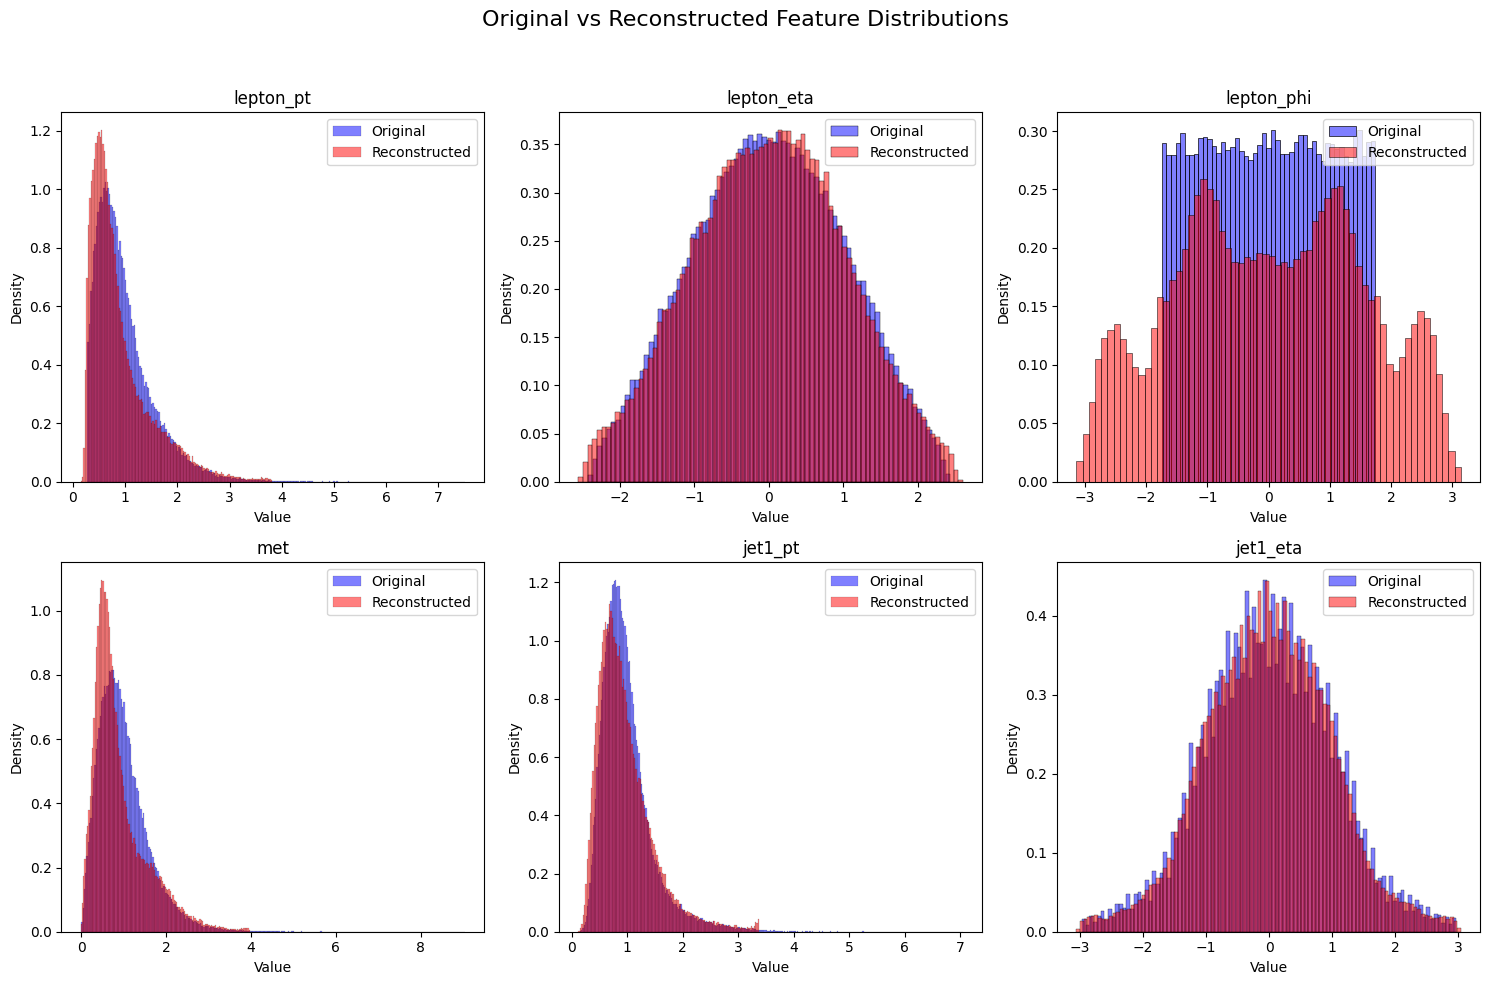

In [ ]:
features = ['lepton_pt', 'lepton_eta', 'lepton_phi', 'met', 'jet1_pt', 'jet1_eta']
indices = [0, 1, 2, 3, 5, 6]

test_original = np.where(np.isinf(test_original), np.nan, test_original)
recon_original = np.where(np.isinf(recon_original), np.nan, recon_original)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Original vs Reconstructed Feature Distributions', fontsize=16)

for i, (feature, idx) in enumerate(zip(features, indices)):
    ax = axes.flat[i]
    sns.histplot(test_original[:, idx], ax=ax, color='blue', label='Original', alpha=0.5, stat='density')
    sns.histplot(recon_original[:, idx], ax=ax, color='red', label='Reconstructed', alpha=0.5, stat='density')
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()